# CryoDRGN interactive filtering

This jupyter notebook provides multiple methods for filtering particles based on the latent space, including:
* clustering of the latent space (k-means or Gaussian mixture model)
* outlier detection (Z-score)
* interactive selection with a lasso tool

For each method, the selected particles are tracked in the variable, `ind_selected`.

Once the selection has been finalized, the selected particles are saved as a `index.pkl` file at the end of this notebook. The selected indices can be provided to cryoDRGN with the `--ind` argument to train a new model on a subset of the images or converted to `.star` file format.

For more information, see the tutorial on [Notion page].

In [1]:
import pandas as pd
import numpy as np
import pickle
import subprocess
import os, sys

from cryodrgn import analysis
from cryodrgn import utils
from cryodrgn import dataset
from cryodrgn import ctf
                
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from ipywidgets import interact, interactive, HBox, VBox
from scipy.spatial.transform import Rotation as RR
py.init_notebook_mode()
from IPython.display import FileLink, FileLinks

In [2]:
# Enable interactive widgets
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


### Load results

In [3]:
# Specify the workdir and the epoch number (0-based index) to analyze
WORKDIR = '..' 
EPOCH = 39 # CHANGE ME

In [4]:
print(os.path.abspath(WORKDIR))

/work/jpma/luo/tomo/warp_DEF/metadata/optomo/zribotmt


In [5]:
# Load z
latents = utils.load_torch_pkl(f'{WORKDIR}/z.{EPOCH}.pkl')
# load composition latent code
z = latents["mu"]
# load conformation latent code
multi_z = latents["multi_mu"]

In [6]:
# Load UMAP
umap = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/umap.pkl')
# or run UMAP
# umap = analysis.run_umap(z)

In [7]:
# Load kmeans
K = 20
kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
kmeans_centers = np.loadtxt(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers.txt')
#kmeans_centers = np.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers.pkl')
#kmeans_centers_ind = np.loadtxt(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/centers_ind.txt', dtype=np.int64)
# Or re-run kmeans with the desired number of classes
#kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 20)

# Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### Define helper functions

In [8]:
def invert_selection(ind_selected):
    return np.array(sorted(set(np.arange(len(z))) - set(ind_selected)))

In [9]:
def combine_selection(ind_sel1, ind_sel2, kind='union'):
    assert kind in ('union','intersection')
    return analysis.combine_ind(len(z), ind_sel1, ind_sel2, kind)

In [10]:
def select_clusters(labels, cluster_ids):
    return analysis.get_ind_for_cluster(labels, cluster_ids)

### Load dataset

In [11]:
# Load configuration file
config = utils.load_pkl(f'{WORKDIR}/config.pkl')
print(config)

{'dataset_args': {'particles': '/work/jpma/luo/tomo/warp_DEF/metadata/optomo/zribotmt/ribotm.star', 'norm': [0, 0.99977463], 'invert_data': True, 'ind': None, 'keepreal': False, 'window': True, 'window_r': 0.85, 'datadir': '/work/jpma/luo/tomo/warp_DEF/metadata/warp_tiltseries', 'ctf': None, 'poses': '/work/jpma/luo/tomo/warp_DEF/metadata/optomo/zribotmt/ribotm_pose_euler.pkl', 'do_pose_sgd': False, 'real_data': True, 'downfrac': 1.0}, 'lattice_args': {'D': 129, 'extent': 0.5, 'ignore_DC': True}, 'model_args': {'qlayers': 3, 'qdim': 256, 'players': 3, 'pdim': 256, 'zdim': 12, 'encode_mode': 'grad', 'enc_mask': 64, 'pe_type': 'vanilla', 'pe_dim': None, 'domain': 'fourier', 'activation': 'relu', 'template_type': 'conv', 'down_vol_size': 114, 'Apix': 3.37, 'templateres': 128}, 'seed': 6776}


In [12]:
# Load poses
pose_pkl = config['dataset_args']['poses']
# you can also load {WORKDIR}/pose.{EPOCH}.pkl
rot, trans, euler = utils.load_pkl(pose_pkl)

In [ ]:
# Convert rotation matrices to euler angles
#euler = RR.from_matrix(rot).as_euler('zyz', degrees=True)

In [13]:
# define the original starfile 
starfile_orig = config['dataset_args']['particles']
from cryodrgn import starfile
starfile_orig = starfile.Starfile.load(starfile_orig)

In [15]:
# Load input particles, change tilt_step, tilt_range according to your data
particles, ctfs, ctf_files, warp_ctf = dataset.load_warp_subtomos(config['dataset_args']['particles'],
                            lazy=True,
                            datadir=config['dataset_args']['datadir'],
                            tilt_step=2, tilt_range=50,)
N_orig = len(particles)
print(f"loaded {N_orig} particles")

### View pose distribution

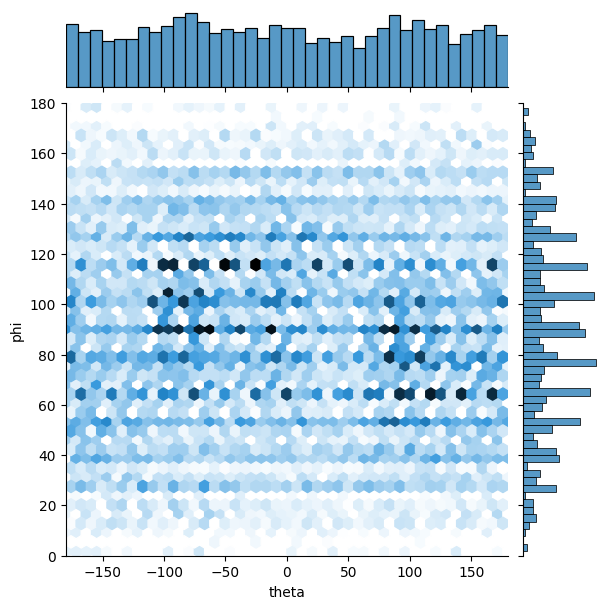

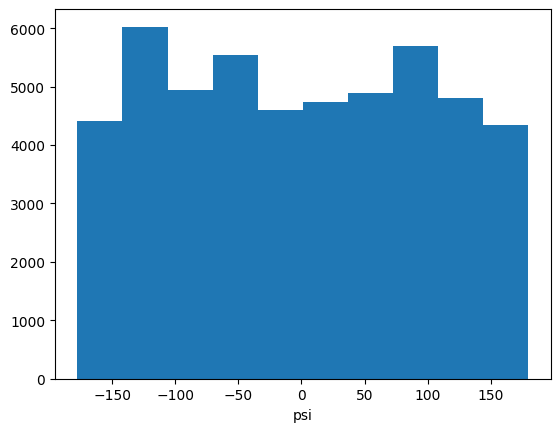

In [16]:
# rotations
analysis.plot_euler(euler[:,0],euler[:,1], euler[:,2])

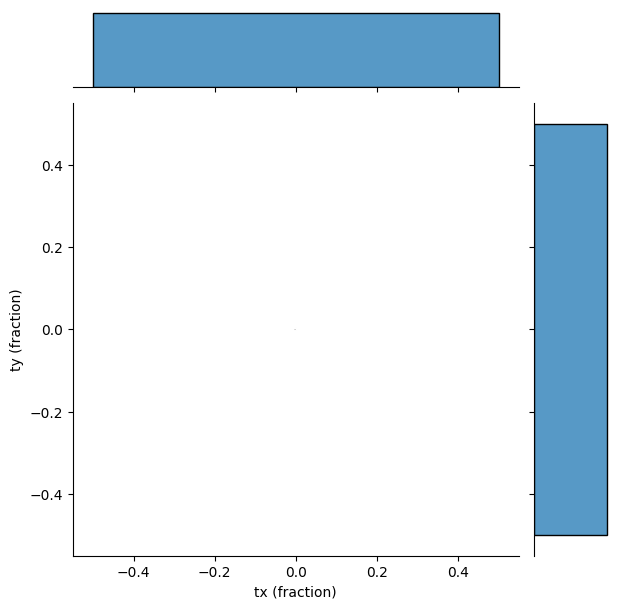

In [16]:
# translations
sns.jointplot(x=trans[:,0],
              y=trans[:,1],
              kind='hex').set_axis_labels('tx (fraction)','ty (fraction)')

### Learning curve

### PCA

In [17]:
pc, pca = analysis.run_pca(z)

2026-01-30 17:06:22     Explained variance ratio:
2026-01-30 17:06:22     [0.19316461 0.1133576  0.09055165 0.08916906 0.08231673 0.07544862
 0.07107299 0.06823767 0.0629412  0.05860259 0.05169187 0.04344541]


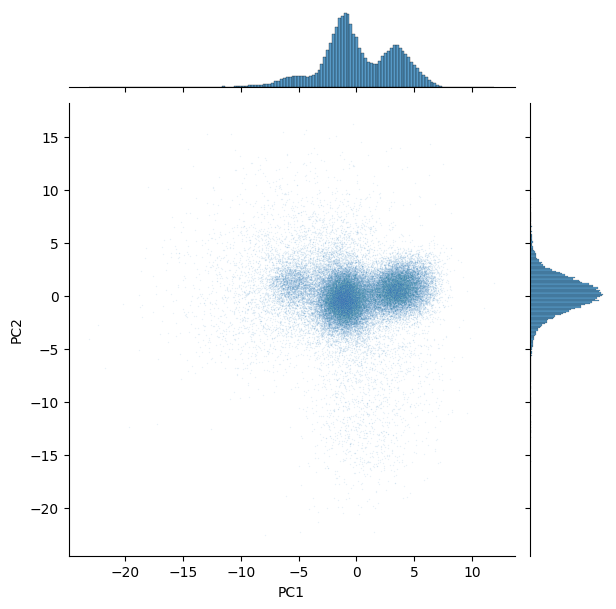

In [18]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], alpha=.1, s=1)
g.set_axis_labels('PC1', 'PC2')

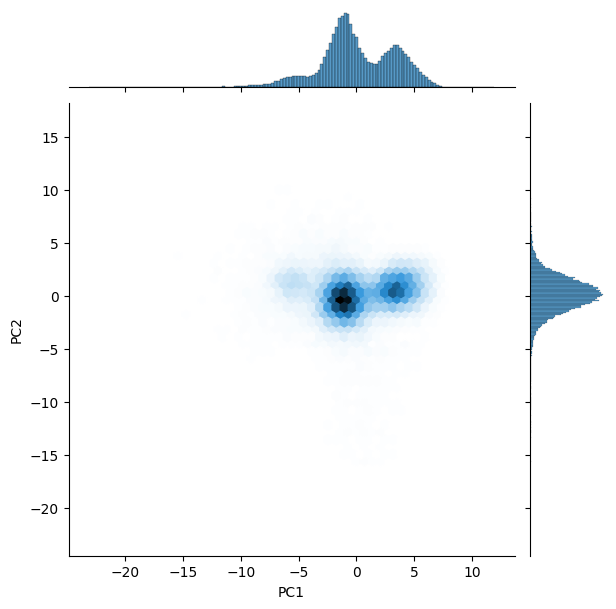

In [19]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], kind='hex')
g.set_axis_labels('PC1', 'PC2')

Text(0, 0.5, 'explained variance')

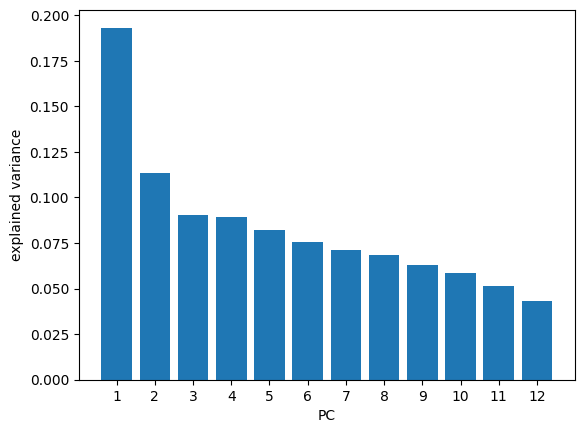

In [20]:
plt.bar(np.arange(z.shape[1])+1,pca.explained_variance_ratio_)
plt.xticks(np.arange(z.shape[1])+1)
plt.xlabel('PC')
plt.ylabel('explained variance')

### UMAP

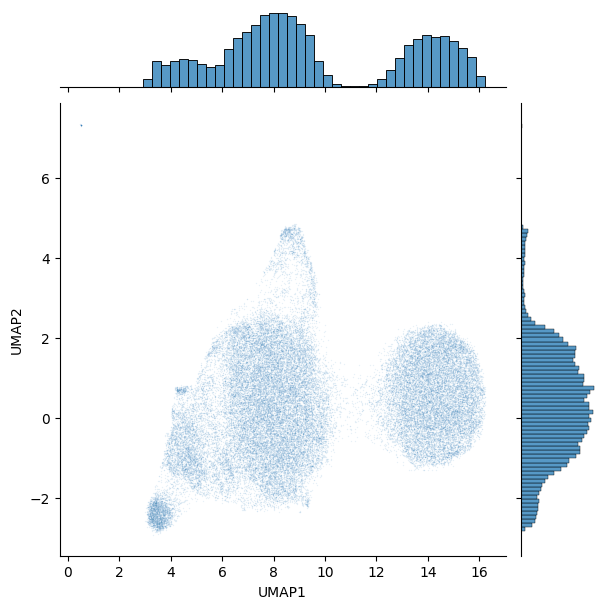

In [21]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')

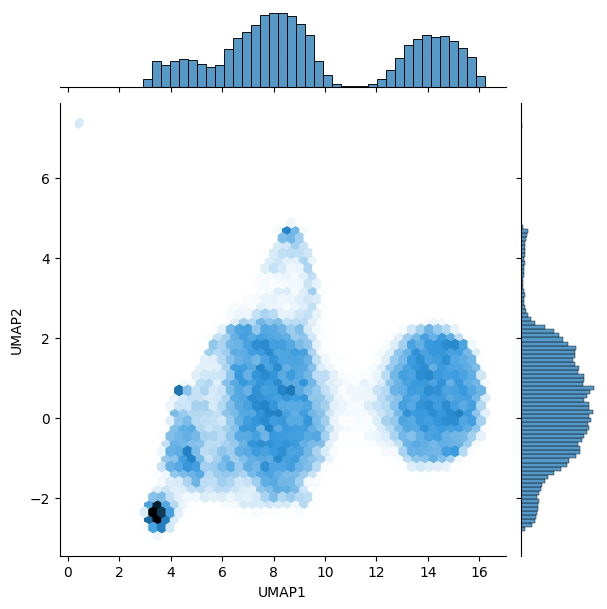

In [22]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

# Filter by clustering

Select particles based on k-means cluster labels or GMM cluster labels

### View K-means clusters

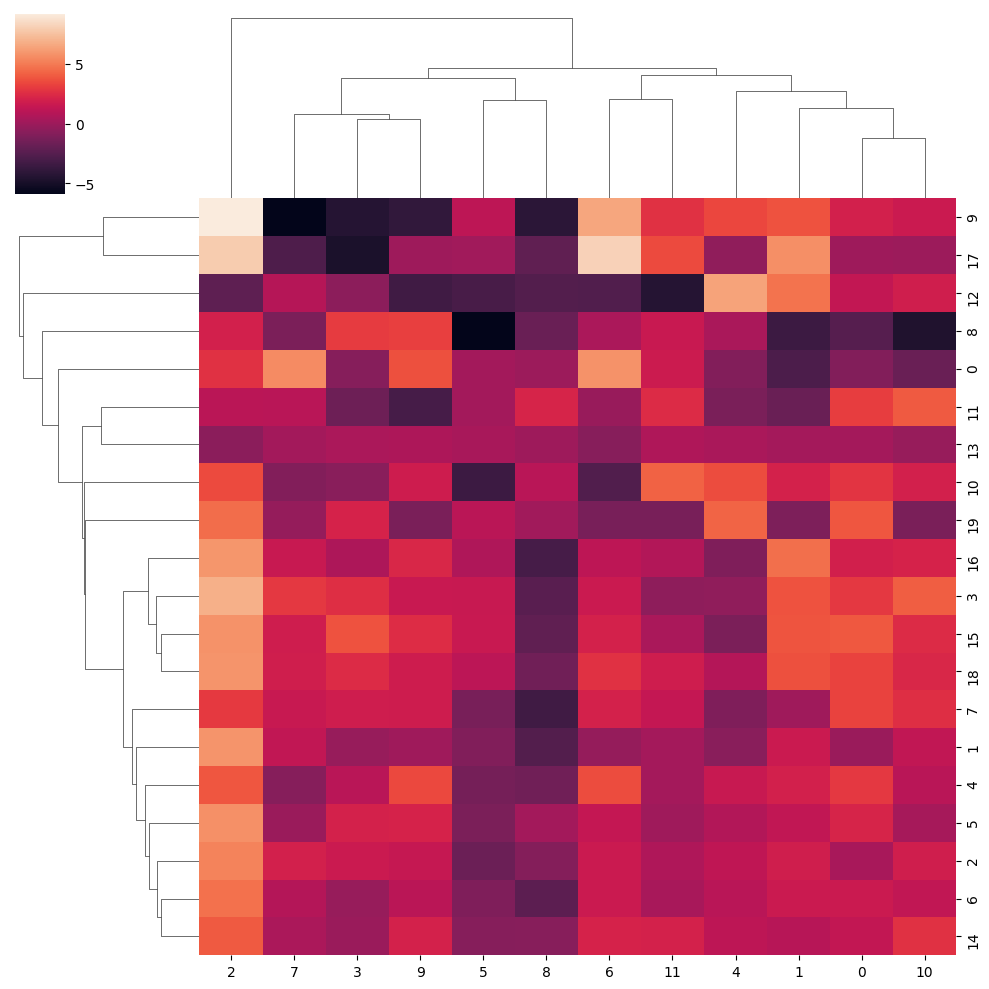

In [23]:
# Optionally, re-run kmeans with the desired number of classes
K = 20
kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, K)
# Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

Text(0, 0.5, 'PC2')

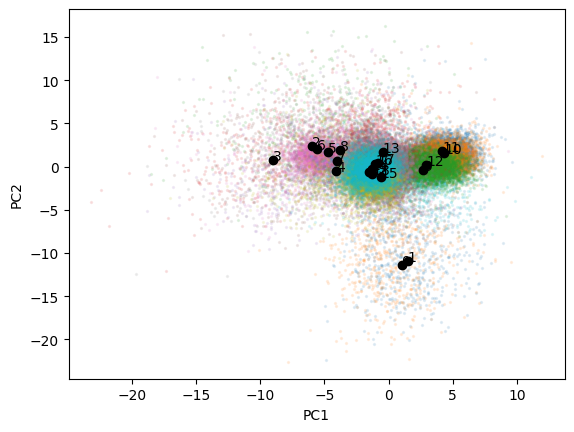

In [24]:
K = len(set(kmeans_labels))
c = pca.transform(kmeans_centers) # transform to view with PCs
analysis.plot_by_cluster(pc[:,0], pc[:,1], K, 
                         kmeans_labels, 
                         centers=c,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

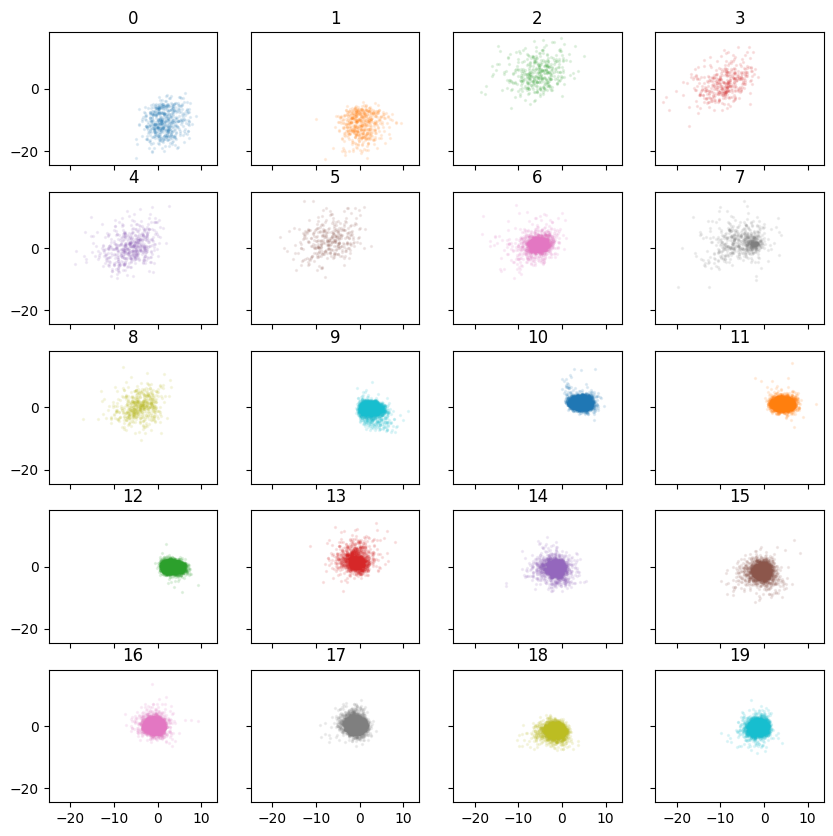

In [25]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], K, 
                            kmeans_labels)

Text(0, 0.5, 'UMAP2')

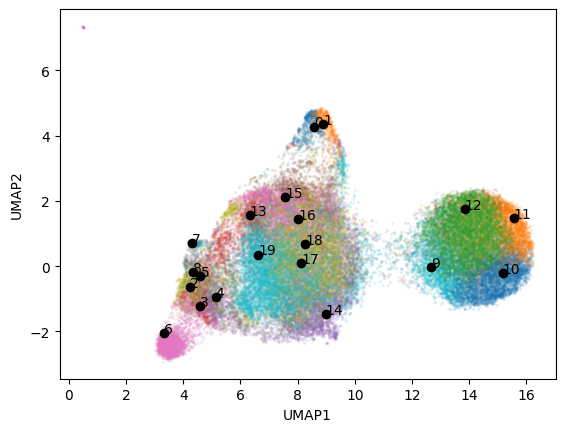

In [26]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], K, 
                         kmeans_labels, 
                         centers_ind=centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

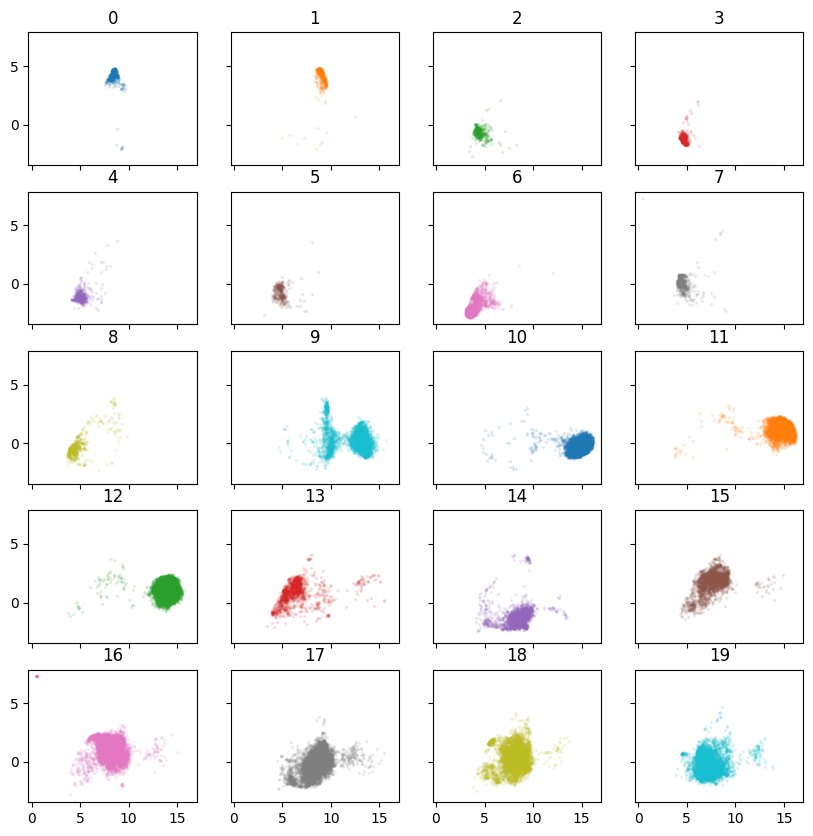

In [27]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], K, 
                            kmeans_labels)

**Select particles based on k-means clustering**

In [28]:
cluster_ids = [9,10,11,12] # set clusters to select, 0 and 2 in this example
ind_selected = select_clusters(kmeans_labels, cluster_ids)
ind_selected_not = invert_selection(ind_selected)
print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[    1     2     4 ... 49796 49836 49876]
Number of selected points:
17445
Number of unselected points:
32555


In [29]:
#save selected ind to starfile
outstar = f"{WORKDIR}/analyze.{EPOCH}/cluster_sel.star"
print(f"write selection to {outstar}")
starfile_orig.write_ind(outstar, ind_selected)

write selection to ../analyze.39/cluster_sel.star


Text(0, 0.5, 'PC2 (0.11)')

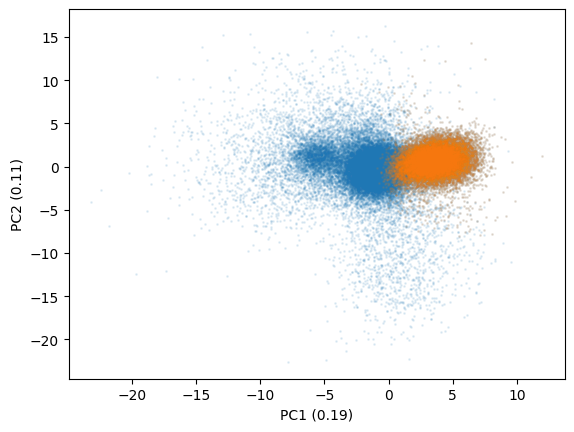

In [30]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

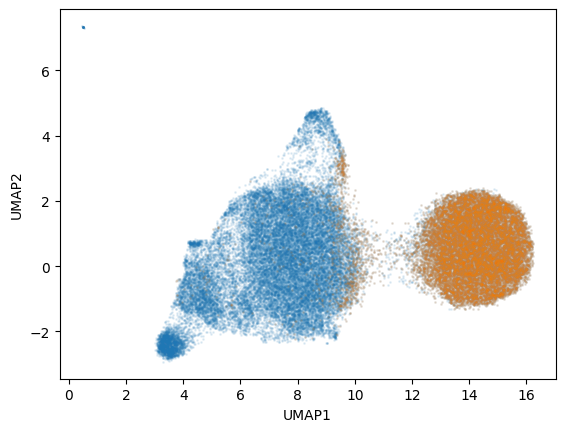

In [31]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

### GMM-clustering

In [38]:
G = 3 # or change to desired cluster number
random_state = np.random.randint(100000) # sample random integer
print(f'Random state: {random_state}')
gmm_labels, gmm_centers = analysis.cluster_gmm(z, G, random_state=random_state)
gmm_centers, gmm_centers_ind = analysis.get_nearest_point(z, gmm_centers)

Random state: 7219


Text(0, 0.5, 'PC2')

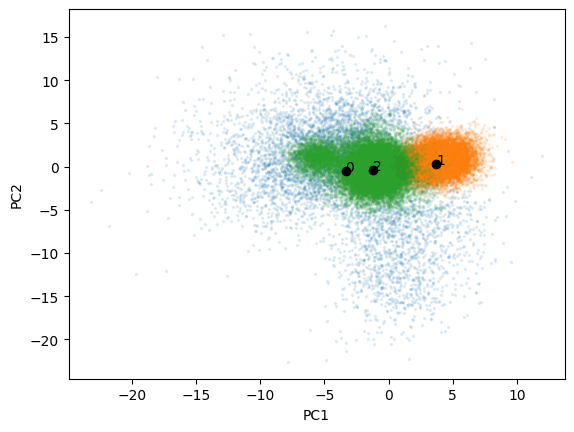

In [39]:
analysis.plot_by_cluster(pc[:,0], pc[:,1], G, 
                         gmm_labels, 
                         centers_ind=gmm_centers_ind,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], G, gmm_labels)

Text(0, 0.5, 'UMAP2')

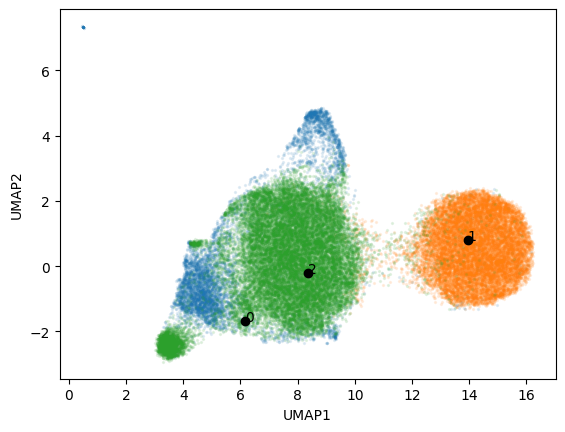

In [40]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], G, 
                         gmm_labels, 
                         centers_ind=gmm_centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

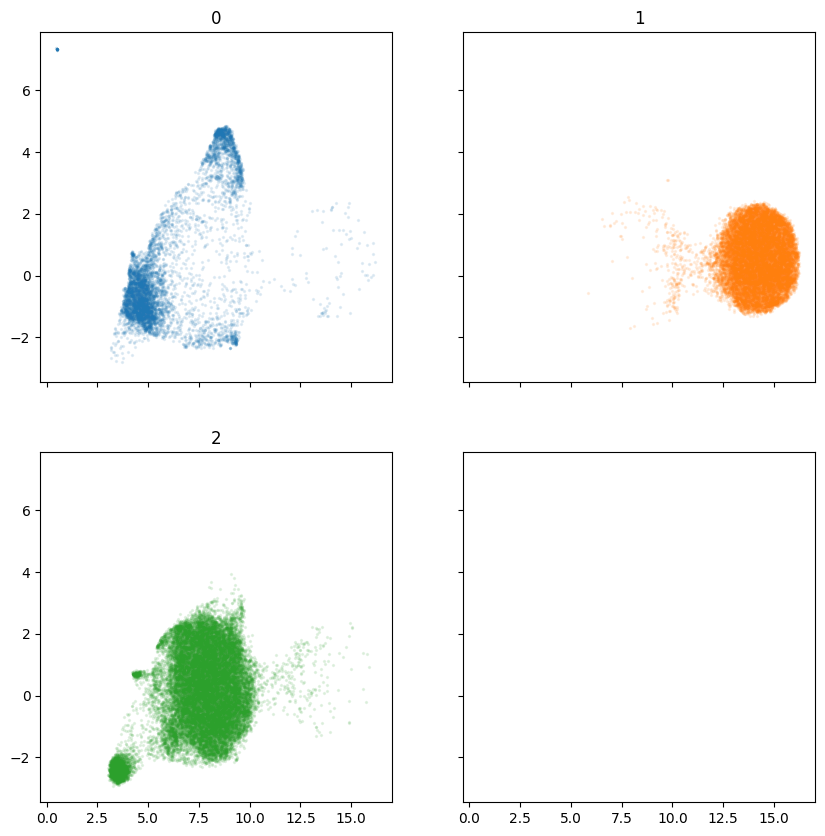

In [41]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], G, gmm_labels)

**Select particles based on GMM-means clustering**

In [43]:
cluster_ids = [1] # set clusters to select, 0 and 2 in this example
ind_selected = select_clusters(gmm_labels, cluster_ids)
ind_selected_not = invert_selection(ind_selected)
print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

Selected indices:
[   53    66   101 ... 49796 49836 49876]
Number of selected points:
16687
Number of unselected points:
33313


Text(0, 0.5, 'PC2 (0.11)')

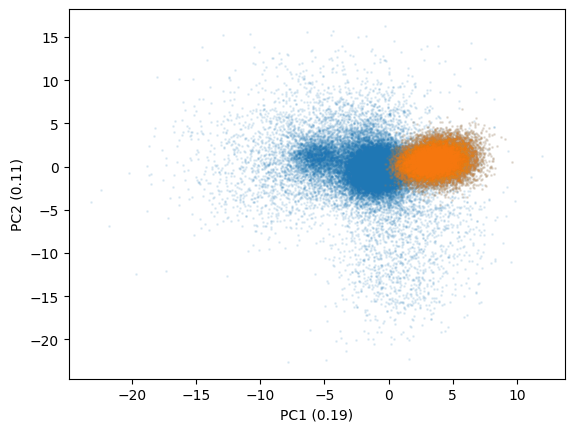

In [44]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

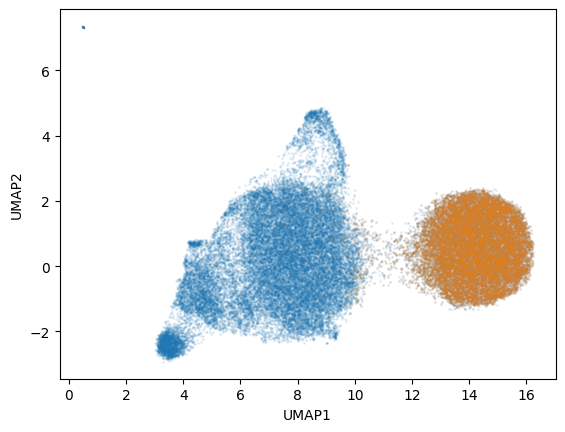

In [45]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Filter outlier particles

In [ ]:
# Compute magnitude of latent encodings
znorm = np.sum(z**2,axis=1)**.5

In [ ]:
# Distribution of ||z||
sns.distplot(znorm, kde=False)
plt.xlabel('||z||')

In [ ]:
# By default, identify particles with ||z|| 2 std deviations above mean
zscore = 2
thresh = znorm.mean()+zscore*znorm.std()
print(f'Mean: {znorm.mean()}, Std: {znorm.std()}, Selected threshold: {thresh}')

In [ ]:
ind_outliers = np.where(znorm >= thresh)[0]
ind_outliers_not = invert_selection(ind_outliers)

print('Selected indices:')
print(ind_outliers)
print('Number of selected points:')
print(len(ind_outliers))
print('Number of unselected points:')
print(len(ind_outliers_not))

In [ ]:
g = sns.distplot(znorm, kde=False)
plt.axvline(x=thresh)
plt.xlabel('||z||')
plt.title('Magnitude of particle latent encodings')

In [ ]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_outliers,0], pc[ind_outliers,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))
plt.title(f'Particles with ||z|| > {thresh}')

In [ ]:
# View UMAP
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_outliers,0], umap[ind_outliers,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title(f'Particles with ||z|| > {thresh}')

In [ ]:
# Assign variables for viz/saving cells at the end of the notebook
ind_selected = ind_outliers
ind_selected_not = ind_outliers_not

# Interactive visualization

Interactive visualization of the latent encodings for the trained model. Each point represents a particle image of the dataset. The hover text includes the index of the image in the particle stack. 

In [ ]:
# Load data into a pandas dataframe
df = analysis.load_dataframe(z=z, 
                             pc=pc, 
                             euler=euler, 
                             trans=trans, 
                             labels=kmeans_labels, 
                             umap=umap,
                             df1=ctf_params[:,2],
                             df2=ctf_params[:,3],
                             dfang=ctf_params[:,4],
                             phase=ctf_params[:,8],
                             znorm=znorm)
df.head()

### Interactive selection

The next two cells contain helper code to select particles using an interactive lasso tool. 

1. In the first cell, select points with the lasso tool. The table widget is dynamically updated with the most recent selection's indices. 
2. Then once you've finalized your selection, **run the next cell** to save the particle indices for downstream analysis/viz.

(Double click to clear selection)

In [ ]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df)
VBox((widget,fig,ind_table))

In [ ]:
ind_selected = ind_table.data[0].cells.values[0] # save table values
ind_selected = np.array(ind_selected)
ind_selected_not = invert_selection(ind_selected)

print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

In [ ]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

In [ ]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# View particles

View images from selected particles

In [29]:
particle_ind = ind_selected # or set to custom selection

In [57]:
# Choose 9 particles to view at random
if len(particle_ind) > 9:
    ind_subset9 = np.random.choice(particle_ind, 9, replace=False)
else: 
    ind_subset9 = particle_ind
print(ind_subset9)

[16203 48801   542  4301  6432 27449 32934 23316  8903]


In [70]:
def circular_mask(shape, radius=None, center=None):
    H, W = shape
    if center is None:
        center = (H//2, W//2)
    if radius is None:
        radius = min(H, W) // 2

    Y, X = np.ogrid[:H, :W]
    dist2 = (Y-center[0])**2 + (X-center[1])**2
    return dist2 <= radius**2

Text(0, 0.5, 'UMAP2')

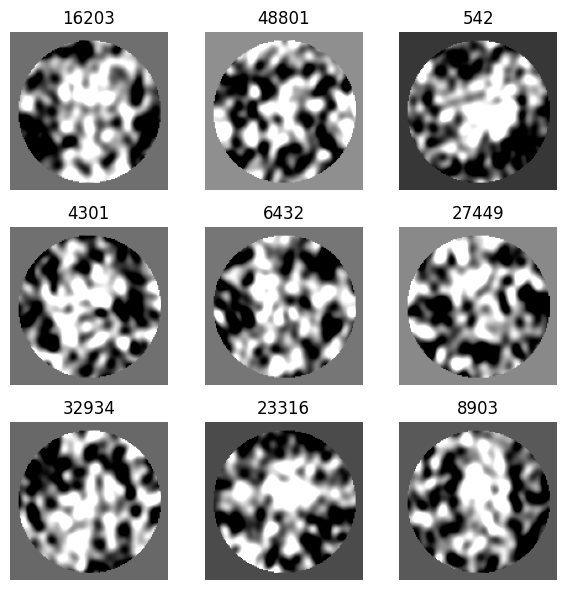

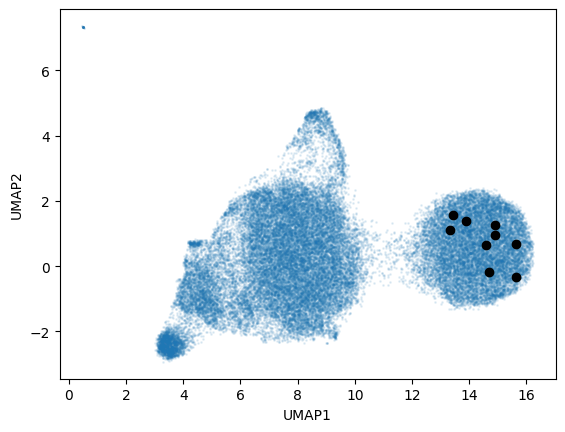

In [73]:
#visualize selection
from scipy.ndimage import gaussian_filter

sigma = 3.5

p = [particles[ii].get().sum(axis=0) for ii in ind_subset9] # z axis projection
p = [gaussian_filter(x, sigma=sigma) for x in p] #gaussian blurring
mask = circular_mask(p[0].shape, radius=p[0].shape[0]//2*0.9) #circular mask
p = [x*mask for x in p]
#_ = analysis.plot_projections(p, ind_subset9)
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for ax, img, ind in zip(axes.flat, p, ind_subset9):   # p = list of 9 images
    vmin, vmax = np.percentile(img, (10, 90))
    ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(ind)

plt.tight_layout()
plt.figure()
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_subset9,0], umap[ind_subset9,1], color='k')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Save selection

Save the particle indices for the selected (`ind_selected`) and unselected particles (`ind_selected_not`) as a .pkl file for downstream processing in cryoDRGN or with other tools.

Rename the paths as desired. Note that the indices will be automatically converted if the current cryoDRGN training run has already been filtered (`ind_orig` loaded in an earlier cell).

In [47]:
# Set selection as either the kept or bad particles (for file naming purposes)
ind_keep = ind_selected # or ind_selected_not
ind_bad = ind_selected_not # or ind_selected

Text(0, 0.5, 'PC2 (0.11)')

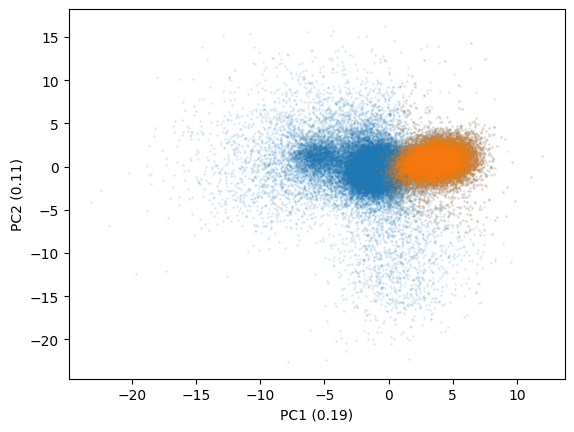

In [48]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_keep,0], pc[ind_keep,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'UMAP2')

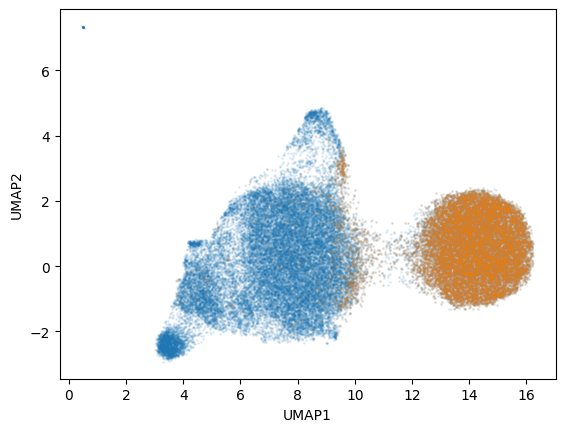

In [49]:
# View UMAP
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_keep,0], umap[ind_keep,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [50]:
print('Kept particle indices:')
print(ind_keep)
print('Number of kept particles:')
print(len(ind_keep))
print('Number of bad particles:')
print(len(ind_bad))

Kept particle indices:
[    1     2     4 ... 49796 49836 49876]
Number of kept particles:
17418
Number of bad particles:
32582
